In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from utils import *
N = 50*50
input_dim = 2
a0 = 0.8
sigma = 4


def split_dataset(X, X_ood, plot=False):

    train, test, X_ood_train, X_ood_test = train_test_split(X, X_ood)
    y_train = train[:, -1]
    y_test = test[:, -1]
    x_train = train[:, 0:2]
    x_test = test[:, 0:2]
    
    if plot:
        plot_train(x_train, y_train)
        plot_data(X_ood_train)

    X_train = torch.from_numpy(train[:, 0:2]).float()
    y_train = torch.from_numpy(train[:, 2:]).long()
    X_test = torch.from_numpy(test[:, 0:2]).float()
    y_test = torch.from_numpy(test[:, 2:]).long()
    X_ood_train = torch.from_numpy(X_ood_train).float()
    X_ood_test = torch.from_numpy(X_ood_test).float()
    
    return X_train, y_train, X_test, y_test, X_ood_train, X_ood_test

# Generate training data
def generate_training_data(N, sigma):
    X, X_ood = generate_toy_dataset(N, sigma=sigma, use_torch = False)
    X_train, y_train, X_test, y_test, X_ood_train, X_ood_test = split_dataset(X, X_ood)
    return X_train, y_train, X_test, y_test, X_ood_train, X_ood_test

In [3]:
# Training
from tqdm import tqdm
from prior_networks import PriorDirichlet
from utils import accuracy
from scipy.stats import entropy
from sklearn.metrics import roc_auc_score

batch_size = 100
epochs = 100
lr = 1e-3


def train_net(net, opt, epochs, X_train, y_train, X_ood_train, batch_size, verbose = True):
    
    loss_per_epoch = []
    for epoch in tqdm(range(epochs)):
        losses = []
        for i in range(len(X_train) // batch_size):
            
            x_batch = X_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            x_ood_batch = X_ood_train[i*batch_size : (i+1)*batch_size]

            opt.zero_grad()
            kloss = net.kl_loss(x_batch, x_ood_batch, y_batch)
            kloss.backward()
            losses.append(kloss.item())
            opt.step()
        if epoch % 10 == 0:
            if verbose:
                print("Epoch {} Loss {}".format(epoch, np.mean(losses)))
                
        #loss_per_epoch.append(np.mean(losses))
    #return loss_per_epoch

# Train net on sigma=0.5, a0=0.8
def build_train_net(sigma, a0):
    net = PriorDirichlet(input_dim = 2, output_dim = 3, a0=a0)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    X_train, y_train, X_test, y_test, X_ood_train, X_ood_test = generate_training_data(N, sigma=sigma)
    train_net(net, opt, epochs, X_train, y_train, X_ood_train, batch_size, verbose = False)
    return net, X_train, y_train

sigma1 = 0.5
sigma2 = 5
a0 = 0.2
net1, X_train_1, y_train_1 = build_train_net(sigma1, a0)
net2, X_train_2, y_train_2 = build_train_net(sigma2, a0)


100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


In [4]:
# Experiments
import os
from scipy.stats import dirichlet
from uncertainty_stats import *


def plot_net(net, x_train, y_train, points,ax1,ax2,ax3, fig, sigma, a0=None):
    
    if a0 is not None:
        ent_title = 'Entropy $\\alpha={}$'.format(a0)
        diff_ent_title = 'Differential Entropy $\\alpha={}$'.format(a0)

    else:
        ent_title = 'Entropy $\sigma={}$'.format(sigma)
        diff_ent_title = 'Differential Entropy $\sigma={}$'.format(sigma)
    
    if ax1 is not None:
        plot_train(x_train.numpy(), y_train.numpy().squeeze(), ax1)
        
    mean, alpha, prec = net(to_torch(points))
    ent = get_entropy(mean)
    plot_contour(points, ent, ent_title, ax = ax2,fig=fig)
    diff_entropy = calc_dirichlet_differential_entropy(alpha.detach().numpy())
    plot_contour(points, diff_entropy, diff_ent_title,ax = ax3, fig=fig)

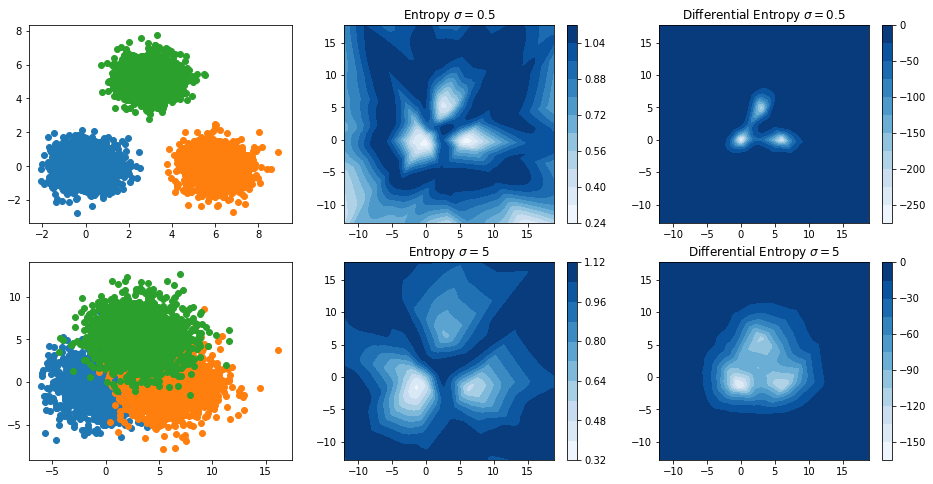

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
points = generate_points(X_train_1, y_train_1)
plot_net(net1, X_train_1, y_train_1, points, axs[0][0],axs[0][1], axs[0][2], fig, sigma=sigma1)
plot_net(net2, X_train_2, y_train_2, points, axs[1][0],axs[1][1], axs[1][2], fig, sigma=sigma2)

if not os.path.exists('plots'):
    os.mkdir('plots')
    
fig.savefig('plots/prior_entropy.png')

In [6]:
# Estimating effect of precision
sigma = 5
a0_1 = 0.2
a0_2 = 1
a0_3 = 5

net1, X_train_1, y_train_1 = build_train_net(sigma, a0_1)
net2, X_train_2, y_train_2 = build_train_net(sigma, a0_2)
net3, X_train_3, y_train_3 = build_train_net(sigma, a0_3)

100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


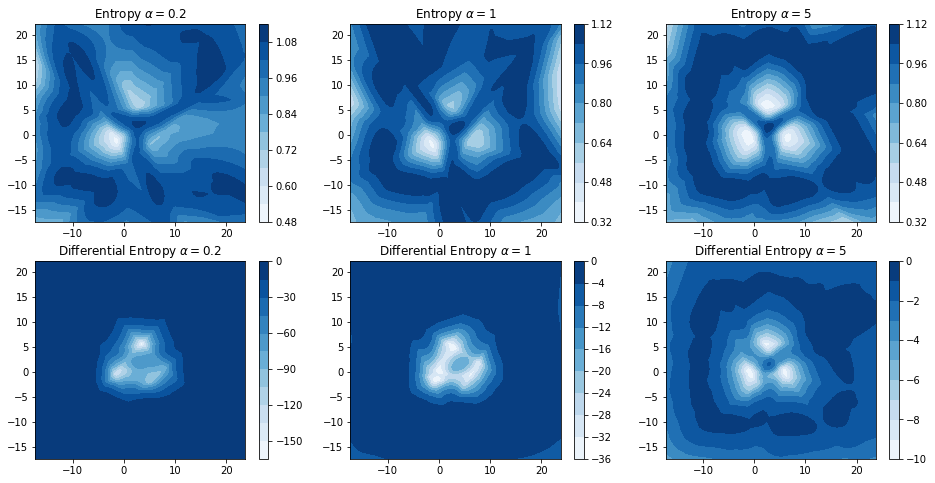

In [7]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
points = generate_points(X_train_1, y_train_1)

plot_net(net1, X_train_1, y_train_1, points, None,axs[0][0], axs[1][0], fig, sigma=sigma, a0=a0_1)
plot_net(net2, X_train_2, y_train_2, points, None,axs[0][1], axs[1][1], fig, sigma=sigma, a0=a0_2)
plot_net(net3, X_train_3, y_train_3, points, None,axs[0][2], axs[1][2], fig, sigma=sigma, a0=a0_3)
fig.savefig('plots/precision_entropy.png')

In [8]:
#MNIST EXPERIMENTS
%load_ext autoreload
%autoreload 2
import torchvision
from torchvision import datasets, transforms
import torch

from prior_networks import PriorCNN

batch_size = 16

mnist_train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

omni_train_loader = torch.utils.data.DataLoader(
        datasets.Omniglot('../data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize((28,28)),
                           transforms.ToTensor()
                       ])),
        batch_size=batch_size, shuffle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified


In [9]:
# Train network
from torch.optim import Adam
a0 = 0.8
net = PriorCNN(input_dim = 1, output_dim=10, a0=a0)
opt = Adam(net.parameters(), lr=2e-3)
n_iter = 100
print_every = 10

for i in range(0, n_iter):
    opt.zero_grad()
    mnist_img, mnist_label = next(iter(mnist_train_loader))
    mnist_label = mnist_label.unsqueeze(1)
    omni_img, _ = next(iter(omni_train_loader))
    #ood = torch.from_numpy(np.random.randn(*(mnist_img.shape))).float()
    ood = omni_img
    loss = net.kl_loss(mnist_img, ood, mnist_label)
    loss.backward()
    
    opt.step()
    
    if i % print_every == 0:
        print("Epoch {}, Loss {}".format(i, loss.item()))

Epoch 0, Loss 1015.338134765625
Epoch 10, Loss 57.550941467285156
Epoch 20, Loss 56.07716751098633
Epoch 30, Loss 2.231733798980713
Epoch 40, Loss 5.619568824768066
Epoch 50, Loss 0.7937881946563721
Epoch 60, Loss -9.172325134277344
Epoch 70, Loss -4.941035270690918
Epoch 80, Loss -11.197291374206543
Epoch 90, Loss -1.8556842803955078


In [10]:
from scipy.special import digamma
from uncertainty_stats import *
import numpy as np

def get_model_uncertainty_mi(alphas, probs):
    alphas = np.asarray(alphas.detach().numpy()) + 1e-6
    alpha_0 = np.sum(alphas, axis=1, keepdims=True)
    expected_entropy = -np.sum(np.exp(np.log(alphas) - np.log(alpha_0)) * 
                               (digamma(alphas + 1.0) - digamma(alpha_0 + 1)), axis=1, keepdims=True)
    
    probs = np.asarray(probs.detach().numpy()) + 1e-6
    entropy_expected = np.asarray([entropy(prob_i) for prob_i in probs])[:, None]
    return entropy_expected


def get_all_uncertainty(probs, alphas, prec):
    mi_uncertainty = get_model_uncertainty_mi(alphas, probs).squeeze()
    diff_entropy = calc_dirichlet_differential_entropy(alphas.detach().numpy())
    ent = get_entropy(probs)
    max_prob = torch.max(probs, 1)[0].detach().numpy()
    
    return {
        'mi' : mi_uncertainty,
        'diff_entropy': diff_entropy,
        'entropy': ent,
        'max_prob': max_prob}

        
def update_accumulator(accumulator, item):
    if len(accumulator) == 0:
        accumulator.update(item)
        return accumulator
    
    to_return = {}
    for k,v in accumulator.items():
        np_arr = item[k]
        v = np.append(v, np_arr, -1)
        to_return[k] = v
    return to_return
        
        
        
in_domain_accumulator = dict()
out_domain_accumulator = dict()

n_iter = 100

# Inference
for i in tqdm(range(0, n_iter)):
    mnist_img, _ = next(iter(mnist_test_loader))
    # next items of the omni_train_loader will be distinct from those used in training
    omni_img, _ = next(iter(omni_train_loader)) 

    # Real
    probs, alphas, prec = net(mnist_img)
    in_uncertainty = get_all_uncertainty(probs,alphas,prec)
    in_domain_accumulator = update_accumulator(in_domain_accumulator, in_uncertainty)
    
    # OOD
    probs_ood, alphas_ood, prec_ood = net(omni_img)
    out_uncertainty = get_all_uncertainty(probs_ood,alphas_ood,prec_ood) 
    out_domain_accumulator = update_accumulator(out_domain_accumulator, out_uncertainty)




100%|██████████| 100/100 [00:02<00:00, 37.45it/s]


In [11]:
from sklearn.metrics import roc_curve
import os

def roc_score(domain_labels, in_measure, out_measure, measure_name, pos_label=1, show=True):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.float128)
    fpr, tpr, thresholds = roc_curve(domain_labels, scores)
    roc_auc = roc_auc_score(domain_labels, scores)
    print("{} ROC AUC".format(measure_name), roc_auc)
    return roc_auc
    
def get_roc_for_uncertainty(in_accumulator, out_accumulator, measure):
    in_uncertainties = in_accumulator[measure]
    out_uncertainties = out_accumulator[measure]
    in_domain_label = np.zeros_like(in_uncertainties)
    out_domain_label = np.ones_like(out_uncertainties)
    
    domain_labels = np.concatenate((in_domain_label, out_domain_label), axis=0)

    return roc_score(domain_labels, in_uncertainties, out_uncertainties, measure)


mi ROC AUC 1.0
diff_entropy ROC AUC 1.0
entropy ROC AUC 1.0
max_prob ROC AUC 4.296875000000048e-06


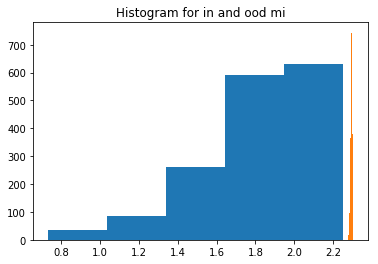

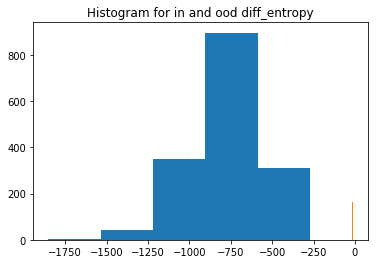

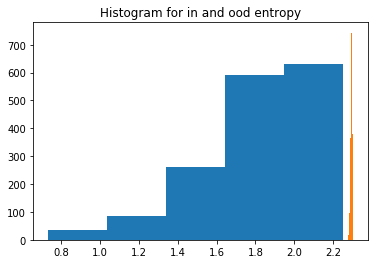

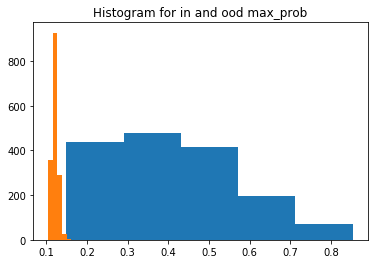

In [12]:
# Get ROC for each uncertainty measure
for key in in_domain_accumulator.keys():
    get_roc_for_uncertainty(in_domain_accumulator, out_domain_accumulator, key)

# Plot Histograms
for key in in_domain_accumulator.keys():
    plt.figure()
    plt.hist(in_domain_accumulator[key], bins = 5, label = ['in'])
    plt.hist(out_domain_accumulator[key], bins = 5, label = ['ood'])
    plt.title(f'Histogram for in and ood {key}')